In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('airline-passengers.csv',index_col='Month',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


<Axes: xlabel='Month'>

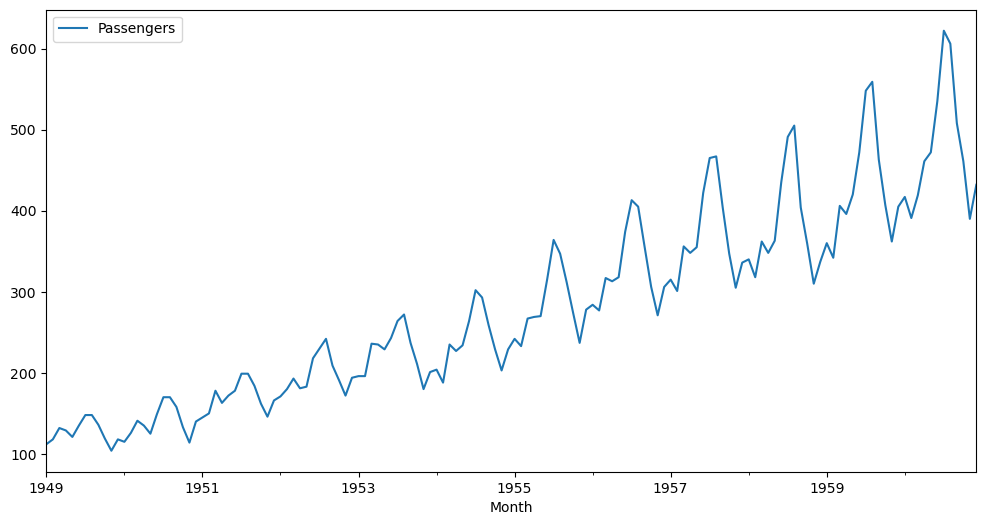

In [4]:
df.plot(figsize=(12,6))

Here we can see that there is a clear seasonality repeating pattern and a general increasing trend. To better understand this, we are goint to decompose the series into its different components using the stats models.

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

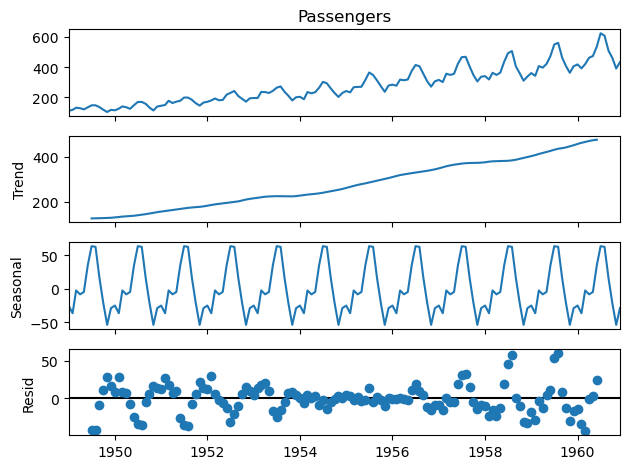

In [6]:
# Decomposing the Data
results = seasonal_decompose(df['Passengers'])
results.plot();

After isolating the trend and removing the seasonal pattern, we can see the increasing trend with time and the seasonal part of the graph separated.

Knonwing how other models work, now we should also check the stationarity of the data, but recurrent neural networks are abble to perform on non-stationary data as well (in part, because they can learn complex patterns), so we are going to skip that for now.

In [7]:
len (df)

144

In [ ]:
# We are going to leave tha last 12 month as the testing set
train = df.iloc[:132]
test = df.iloc[132:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            Passengers
 Month                 
 1949-01-01         112
 1949-02-01         118
 1949-03-01         132
 1949-04-01         129
 1949-05-01         121,
             Passengers
 Month                 
 1960-08-01         606
 1960-09-01         508
 1960-10-01         461
 1960-11-01         390
 1960-12-01         432)

In [11]:
# We will use the scaler to convert the dataset into a scale from o to one
# so que can ensure that there is no difference in magnitudes.
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.01758242],
       [0.03076923],
       [0.06153846],
       [0.05494505],
       [0.03736264],
       [0.06813187],
       [0.0967033 ],
       [0.0967033 ],
       [0.07032967],
       [0.03296703]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
# Define generator for testing with an input of 3 months
n_imput = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_imput,batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.01758242 0.03076923 0.06153846]
Predict this y: 
[[0.05494505]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
# We do the same thing, but now instead for 12 months
n_imput = 12
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_imput,batch_size=1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
# Define de model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape=(n_imput, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Fit the model
model.fit(generator,epochs=50)

Epoch 1/50
120/120 [==============================] - 1s 3ms/step - loss: 0.0289
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 13/50
120/120 [====

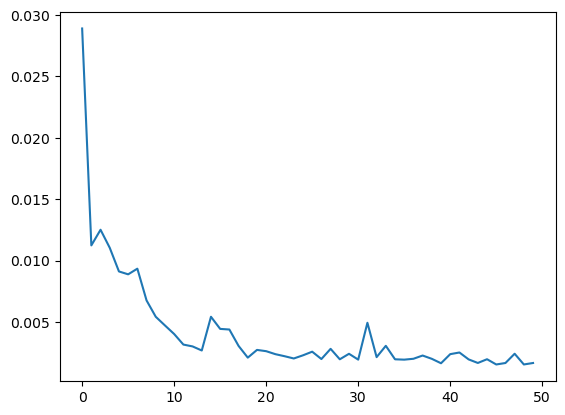

In [22]:
# Lets plot the loss per epoch to see it decreasing after each run
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Reshape the data**

In [23]:
last_train_batch = scaled_train[-12:]

In [24]:
last_train_batch = last_train_batch.reshape((1, n_imput, n_features))

In [25]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 123ms/step


array([[0.62415206]], dtype=float32)

In [26]:
scaled_test[0]

array([0.68791209])

**Making Predictions**

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-n_imput:]
current_batch = first_eval_batch.reshape((1, n_imput, n_features))

for i in range(len(test)):
    
    # Get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # Append the prediction into the array
    test_predictions.append(current_pred) 
    
    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 13ms/step


In [28]:
test_predictions

[array([0.62415206], dtype=float32),
 array([0.6383972], dtype=float32),
 array([0.6971118], dtype=float32),
 array([0.73091096], dtype=float32),
 array([0.81177646], dtype=float32),
 array([0.95532477], dtype=float32),
 array([1.101531], dtype=float32),
 array([1.1005276], dtype=float32),
 array([0.93956196], dtype=float32),
 array([0.7783271], dtype=float32),
 array([0.7112677], dtype=float32),
 array([0.7079678], dtype=float32)]

In [29]:
test

,Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


In [30]:
# Lets transform it back into the original scale
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
# Now append the predictions to the test dataset
test['predictions'] = true_predictions
test

C:\Users\alefu\AppData\Local\Temp\ipykernel_27148\35693500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


,Passengers,predictions
Month,,
1960-01-01,417,387.989189
1960-02-01,391,394.470734
1960-03-01,419,421.185862
1960-04-01,461,436.564485
1960-05-01,472,473.358289
1960-06-01,535,538.672770
1960-07-01,622,605.196618
1960-08-01,606,604.740078
1960-09-01,508,531.500693


<Axes: xlabel='Month'>

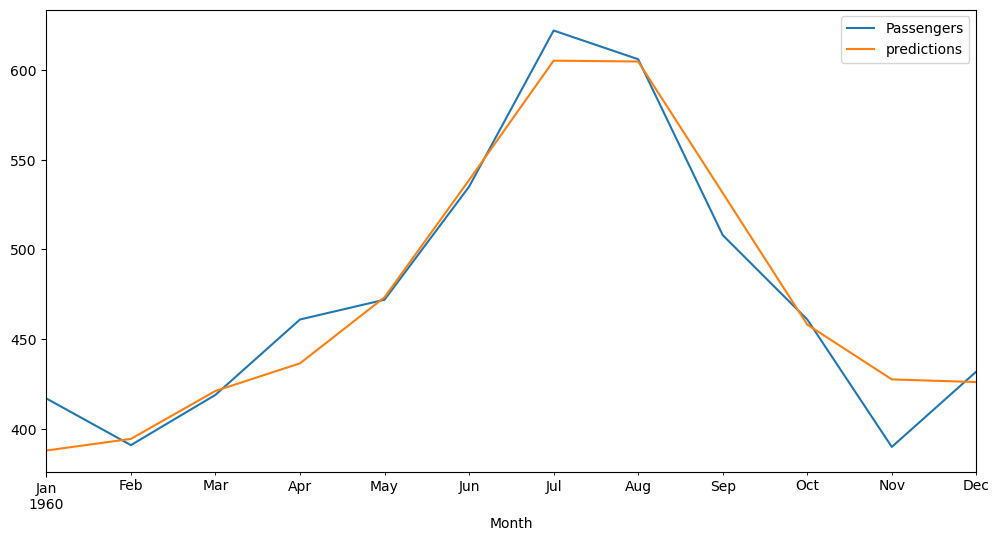

In [32]:
test.plot(figsize=(12,6))

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Passengers'],test['predictions']))
print(rmse)

17.714348450533976


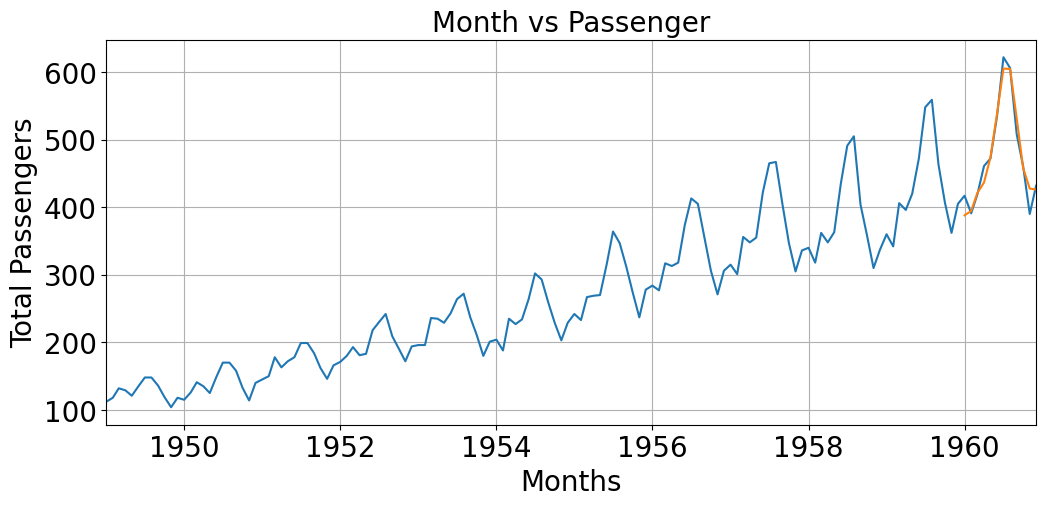

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df['Passengers'])
plt.plot(test['predictions'])

In [35]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['Passengers'], test['predictions'])

print(mae)

12.671716183423996
